In [1]:
import math
import datasets
import debug_helpers
import datetime

import collections
import aer
import warnings
import numpy as np

import persistence
import plots
import random
import convergence_criterion as cc


# pretty print variabeles on line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# returns list with jump probabilities 
# (and special NULL jump probability)
# [-max_jump ....0 ...max_jump, NULL_jump]
def initialize_jump_probs_uniformly(sentence_pairs):
    max_jump = 0
    for (s_sentence, t_sentence) in sentence_pairs:
        s_length = len(s_sentence) - 1 #ignore NULL
        t_length = len(t_sentence)
        jump_1 = abs(1 - math.floor(s_length))
        jump_2 = abs(s_length - math.floor(s_length/t_length))
        max_jump = max(jump_1, jump_2, max_jump)
    init_prob = 1. / (2*max_jump + 1 + 1) # last item is special NULL jump prob
    return [init_prob] * (2*max_jump + 1 + 1)

def initialize_jump_probs_randomly(sentence_pairs):
    max_jump = 0
    for (s_sentence, t_sentence) in sentence_pairs:
        s_length = len(s_sentence) - 1 #ignore NULL
        t_length = len(t_sentence)
        jump_1 = abs(1 - math.floor(s_length))
        jump_2 = abs(s_length - math.floor(s_length/t_length))
        max_jump = max(jump_1, jump_2, max_jump)
    probs_length = 2*max_jump + 1 + 1 # last item is special NULL jump prob
    randoms = [random.random() for i in range(probs_length)]
    sum_randoms = sum(randoms)
    return [r/sum_randoms for r in randoms]

# returns the index in the jump_probabilities list
# for given source and target positions and sentence lengths
# s_pos and s_length for source sentence including the special NULL word
# sentence positions start at index 0
def get_jump_prob_index(s_pos, t_pos, s_length, t_length, jump_probs):
    if s_pos == 0:
        return len(jump_probs) - 1
    jump = int(s_pos - math.floor((t_pos + 1) * (s_length - 1) / t_length))
    max_jump = int((len(jump_probs) - 2)/2)
    jump_prob_index = jump + max_jump
    if jump_prob_index < 0:
        warnings.warn(
            f'Jump prob index {jump_prob_index} (jump:{jump}) out of range.'
        )
        return 0 #approximate with prob of largest negative jump
    if jump_prob_index >= len(jump_probs) - 1:
        warnings.warn(
            f'Jump prob index {jump_prob_index} (jump:{jump}) out of range.'
        )
        return len(jump_probs) - 2 #approximate with prob of largest positive jump

    return jump_prob_index

# returns jump probability for given source and target positions
# and lengths. Positions start at index 0, source sentence contains
# special NULL word at position 0
def get_jump_prob(s_pos, t_pos, s_length, t_length, jump_probs):
    jump_prob_index = get_jump_prob_index(s_pos, t_pos, s_length, t_length, jump_probs)
    return jump_probs[jump_prob_index]

In [3]:
# {Hause: { book:0.25, ...}, ...}
# read: the probability of 'book' given 'Haus' is 0.25
def initialize_lprobs_uniform(s_t_pairs, target_vocabulary):
    p_init = 1./len(target_vocabulary)
    lexicon_probabilities = collections.defaultdict(
        lambda: collections.defaultdict(lambda: p_init))
    return lexicon_probabilities

def initialize_lprobs_staged(s_t_pairs, target_vocabulary):
    return persistence.load_ibm1_model('ibm1_iter_5.txt')

def initialize_lprobs_randomly(s_t_pairs, target_vocabulary):
    # find all word combinations in sentence pairs
    s_t_combinations = ((s_word, t_word) 
          for (s_sentence, t_sentence) in s_t_pairs 
          for s_word in s_sentence 
          for t_word in t_sentence)

    # set random probabilities for word combinations
    lprobs = collections.defaultdict(lambda: collections.defaultdict(lambda: float('NaN')))
    for (s, t) in s_t_combinations:
        lprobs[s][t] = random.random()

    # normalize probabilities
    for s_key, t_dict in lprobs.items():
        total = sum(t_dict.values())
        for (t_key, r) in t_dict.items():
            t_dict[t_key] = t_dict[t_key] / total
    return lprobs

In [4]:
def source_dependencies(s_sentence, t_word, t_pos, t_length, lprobs, jump_probs):
    s_length = len(s_sentence)    
    jump_probs = [get_jump_prob(
        s_word_pos, t_pos, s_length, t_length, jump_probs
    ) for s_word_pos in range(s_length)]
    sum_jump_probs = sum(jump_probs)
    
    return [
        (jump_probs[s_pos]/ sum_jump_probs) * lprobs[s_word][t_word] 
        for s_pos, s_word in enumerate(s_sentence)
    ]

In [5]:
def align(lprobs, jump_probs, sentence_pairs):
    if isinstance(sentence_pairs, tuple):
        return _align_sentence_pair(lprobs, jump_probs, sentence_pairs)
    return [ _align_sentence_pair(lprobs, jump_probs, sentence_pair) for sentence_pair in sentence_pairs ]

def _align_sentence_pair(lprobs, jump_probs, sentence_pair):
    s_sentence = sentence_pair[0]
    t_sentence = sentence_pair[1]
    s_length = len(s_sentence)
    t_length = len(t_sentence)
    best_alignment = set()
    for t_pos, t_word in enumerate(t_sentence):
        sd = source_dependencies(s_sentence, t_word, t_pos, t_length, lprobs, jump_probs)
        (best_align_pos, _) = max(enumerate(sd), key=lambda t: t[1])
        if (best_align_pos > 0): # Leave out NULL-alignments (and alignments between unseen words)
            best_alignment.add((best_align_pos, t_pos + 1)) # word positions start at 1
    return best_alignment

In [6]:
def EM(s_t_pairs, s_vocabulary, t_vocabulary, fn_init_lprobs, fn_init_jump_probs, max_iterations = 10,
        val_sentence_pairs = None, reference_alignments = None, fn_debug = None):
    lprobs = fn_init_lprobs(s_t_pairs, t_vocabulary)
    jump_probs = fn_init_jump_probs(s_t_pairs)
#    print('initial jump probs', jump_probs)
    i = 0
    log_likelihoods = []
    AERs = []
    while i < max_iterations:
        
        # initialize
        log_likelihood = 0
        AER = 0
        counts_t_given_s = collections.defaultdict(lambda: collections.defaultdict(int))
        total_s = collections.defaultdict(int)
        jump_counts = [0]*len(jump_probs)

        # calculate counts and log likelihood
        for (s_sentence, t_sentence) in s_t_pairs:
            s_length = len(s_sentence)
            t_length = len(t_sentence)
            for t_pos, t_word in enumerate(t_sentence):
                prob_counts = source_dependencies(
                    s_sentence, t_word, t_pos, t_length, lprobs, jump_probs)
                s_total_t = sum(prob_counts)
                log_likelihood += math.log(s_total_t)
                                
                for s_pos, s_word in enumerate(s_sentence):
                    update = prob_counts[s_pos]/s_total_t
                    counts_t_given_s[s_word][t_word] += update
                    total_s[s_word] += update
                    jump_count_index = get_jump_prob_index(s_pos, t_pos, s_length, t_length, jump_probs)
                    jump_counts[jump_count_index] += update 
        
        # store log_likelihood and AER values
        log_likelihoods.append(log_likelihood)
        if val_sentence_pairs and reference_alignments:
            predicted_alignments = align(lprobs, jump_probs, val_sentence_pairs)
            AER = aer.calculate_AER(reference_alignments, predicted_alignments)
            AERs.append(AER)

        # print debug info
        if fn_debug:
            fn_debug(i, lprobs, log_likelihood, AER, jump_probs)

        # update probabilities
        for s in lprobs.keys():
            for t in lprobs[s].keys():
                lprobs[s][t] = counts_t_given_s[s][t]/total_s[s]
        
        jump_count_sum = sum(jump_counts)
        jump_probs = [jc/jump_count_sum for jc in jump_counts]

        # update iteration number
        i += 1

    # add AER after final update
    if val_sentence_pairs and reference_alignments:
        predicted_alignments = align(lprobs, jump_probs, val_sentence_pairs)
        AER = aer.calculate_AER(reference_alignments, predicted_alignments)
        AERs.append(AER)
    
    # add llhood after final update
    log_likelihood = 0
    for (s_sentence, t_sentence) in s_t_pairs:
        s_length = len(s_sentence)
        t_length = len(t_sentence)
        for t_pos, t_word in enumerate(t_sentence):
            prob_counts = source_dependencies(
                s_sentence, t_word, t_pos, t_length, lprobs, jump_probs)
            s_total_t = sum(prob_counts)
            log_likelihood += math.log(s_total_t)

    return lprobs, jump_probs, log_likelihoods, AERs


In [9]:
s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_word_order()
(lprobs, jump_probs, _, _) = EM(s_t_pairs, s_vocabulary, t_vocabulary, 
                                initialize_lprobs_randomly, initialize_jump_probs_randomly,
                 fn_debug = None) #debug_helpers.print_likelihood debug_helpers.print_lexicon_probs

# assert(round(lprobs['Haus']['house'], 5) == 1.)
# assert(round(lprobs['Welt']['world'], 5) == 1.)
# assert(round(lprobs['das']['the'], 5) == 1.)
# assert(round(lprobs['<NULL>']['house'], 5) == 0.)
# assert(round(lprobs['<NULL>']['the'], 5) == 0.49987)

# assert(round(jump_probs[0], 5) == 0.49999)
# assert(round(jump_probs[1], 5) == 0.0)
# assert(round(jump_probs[2], 5) == 0.48086)
# assert(round(jump_probs[3], 5) == 0.01915)

# print('PASSED!')

s_t_pairs
debug_helpers.print_lexicon_probs(None, lprobs, None, None)
jump_probs



[(['<NULL>', 'Haus', 'das'], ['the', 'house']),
 (['<NULL>', 'Buch', 'das'], ['the', 'book']),
 (['<NULL>', 'Buch', 'ein'], ['a', 'book']),
 (['<NULL>', 'Maus', 'ein'], ['a', 'mouse']),
 (['<NULL>', 'Hund', 'das'], ['the', 'dog']),
 (['<NULL>', 'Welt', 'ein'], ['a', 'world']),
 (['<NULL>', 'Boot', 'das'], ['the', 'boat']),
 (['<NULL>', 'Brugge', 'ein'], ['a', 'bridge'])]

<NULL> the 0.44200739978014436
<NULL> house 4.358410591383152e-08
<NULL> book 0.0012713609922102
<NULL> a 0.5567004689351671
<NULL> mouse 1.7353193738966208e-06
<NULL> dog 8.034046113922394e-07
<NULL> world 1.571638139369859e-05
<NULL> boat 1.0177512777087133e-06
<NULL> bridge 1.4538517156648982e-06
Haus the 1.1658283990939438e-140
Haus house 1.0
das the 1.0
das house 1.9660392145300648e-146
das book 5.92873542325435e-147
das dog 5.283113285231188e-147
das boat 8.015895974610941e-147
Buch the 2.036214959065505e-143
Buch book 1.0
Buch a 1.3336639070192774e-143
ein a 1.0
ein book 1.4777241660550323e-146
ein mouse 8.638469150004248e-147
ein world 8.287837978611856e-146
ein bridge 6.431339646331195e-147
Maus a 1.207412766715251e-140
Maus mouse 1.0
Hund the 1.1919860923949896e-140
Hund dog 1.0
Welt a 2.466049484196884e-140
Welt world 1.0
Boot the 1.2073838592221949e-140
Boot boat 1.0
Brugge a 1.1542720157579969e-140
Brugge bridge 1.0



[0.49999975099836896,
 5.249833027905201e-141,
 0.4998075428625953,
 0.00019270613903572774]

In [ ]:
# Run EM on toy example
s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_null_words()
s_t_pairs[0:3]
(lprobs, jump_probs, _, _) = EM(s_t_pairs[0:3], s_vocabulary, t_vocabulary, 
                 fn_debug = debug_helpers.print_likelihood)

debug_helpers.print_lexicon_probs(None, lprobs, None, None)
jump_probs

In [ ]:
# Run EM on toy example with NULL words
val_sentence_pairs = [(
    ['<NULL>', 'Buch', 'klein', 'das', 'Haus'], 
    ['book', 'small', 'the', 'house']
)]
ref_alignments = [[
    {(3, 1), (2, 2), (4, 3), (1, 4)}, 
    {(3, 1), (2, 2), (4, 3), (1, 4)}
]]
s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_null_words()
s_t_pairs
(lprobs, jump_probs, _, _) = EM(
    s_t_pairs, s_vocabulary, t_vocabulary, 20,
    val_sentence_pairs, ref_alignments, debug_helpers.print_likelihood)
debug_helpers.print_lexicon_probs(None, lprobs, None, None)
jump_probs

In [10]:
def fname_ibm2(i):
    return f'ibm2_iter_{i}.txt'

# After each iteration we print llhood and AER and store the model 
# We can later load the models that meet our convergence criteria
# and apply those to the test data
def fn_after_iter_ibm2(i, lprobs, log_likelihood, AER, jump_probs):
    debug_helpers.print_likelihood(i, lprobs, log_likelihood, AER)
#    if (i == 7) or (i == 9): # AER and LLhoods
#        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(i))

In [ ]:
# Run EM on training data set with AER on validation set
# *** uniform initialization
s_t_pairs, s_vocabulary, t_vocabulary = datasets.training_data()
val_sentence_pairs = datasets.validation_data(s_vocabulary, t_vocabulary)
reference_alignments = datasets.validation_alignments()    

(lprobs, jump_probs, llhoods, AERs) = EM(
    s_t_pairs, s_vocabulary, t_vocabulary, 15,
    initialize_lprobs_uniform,
    val_sentence_pairs, reference_alignments, 
    fn_after_iter_ibm2)


# plot AER and llhood scores vs iteration
plots.figure_log_likelihood(llhoods, 'IBM2')
plots.figure_AER(AERs, 'IBM2')

# select models based on AER and llhood selection criterion
selected_model_AER = fname_ibm2(cc.select_model_AER(AERs))
selected_model_llhood = fname_ibm2(cc.select_model_LLhood(llhoods))
print('model selected on AER:', selected_model_AER)
print('model selected on LLhood:', selected_model_llhood)

# store AER and llhood scores in file
fname_ibm2_AERs = "ibm2_AERs_iter15.txt"    
fname_ibm2_llhoods = "ibm2_llhoods_iter15.txt"
persistence.save(AERs, fname_ibm2_AERs)
persistence.save(llhoods, fname_ibm2_llhoods)

# store model
#persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(10))


In [14]:
def run_em_with_initialization(fn_init, fn_init_jumps, init_name):
    (lprobs, jump_probs, llhoods, AERs) = EM (
        s_t_pairs, s_vocabulary, t_vocabulary, 
        fn_init, fn_init_jumps,
        15,
        val_sentence_pairs, reference_alignments, 
        fn_after_iter_ibm2)

    # store AER and llhood scores in file
    fname_ibm2_AERs = f'ibm2_AERs_{init_name}.txt'    
    fname_ibm2_llhoods = f'ibm2_llhoods_{init_name}.txt'
    persistence.save(AERs, fname_ibm2_AERs)
    persistence.save(llhoods, fname_ibm2_llhoods)

    # select models based on AER and llhood selection criterion
    selected_model_AER = fname_ibm2(cc.select_model_AER(AERs))
    selected_model_llhood = fname_ibm2(cc.select_model_LLhood(llhoods))
    print(f'model selected on AER for {init_name}:', selected_model_AER)
    print(f'model selected on LLhood for {init_name}:', selected_model_llhood)

    # plot AER and llhood scores vs iteration
    plots.figure_log_likelihood(llhoods, f'IBM2_{init_name}')
    plots.figure_AER(AERs, f'IBM2_{init_name}')

iteration    log_likelihood    AER    time
0 -25.935 0.00000 11:49
1 -19.211 0.00000 11:49
2 -15.332 0.00000 11:49
3 -10.946 0.00000 11:49
4 -5.710 0.00000 11:49
5 -2.086 0.00000 11:49
6 -0.890 0.00000 11:49
7 -0.460 0.00000 11:49
8 -0.235 0.00000 11:49
9 -0.119 0.00000 11:49
10 -0.060 0.00000 11:49
11 -0.030 0.00000 11:49
12 -0.015 0.00000 11:49
13 -0.008 0.00000 11:49
14 -0.004 0.00000 11:49
model selected on AER for random_random_1: ibm2_iter_None.txt
model selected on LLhood for random_random_1: ibm2_iter_None.txt


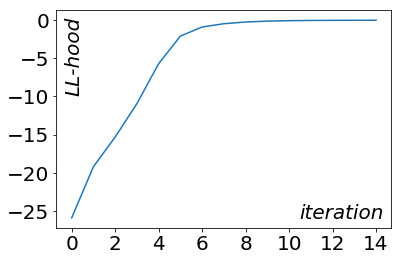

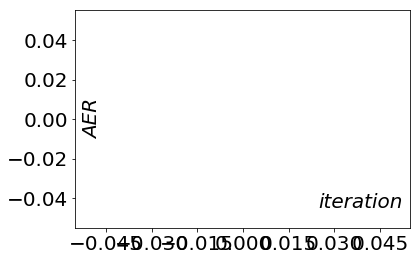

iteration    log_likelihood    AER    time
0 -23.105 0.00000 11:49
1 -11.236 0.00000 11:49
2 -4.771 0.00000 11:49
3 -1.054 0.00000 11:49
4 -0.228 0.00000 11:49
5 -0.102 0.00000 11:49
6 -0.050 0.00000 11:49
7 -0.025 0.00000 11:49
8 -0.012 0.00000 11:49
9 -0.006 0.00000 11:49
10 -0.003 0.00000 11:49
11 -0.002 0.00000 11:49
12 -0.001 0.00000 11:49
13 -0.000 0.00000 11:49
14 -0.000 0.00000 11:49
model selected on AER for random_random_2: ibm2_iter_None.txt
model selected on LLhood for random_random_2: ibm2_iter_None.txt


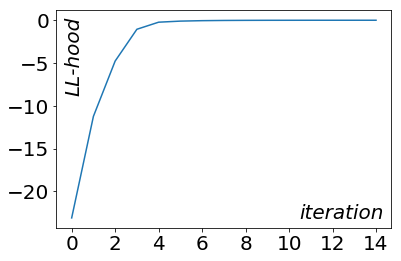

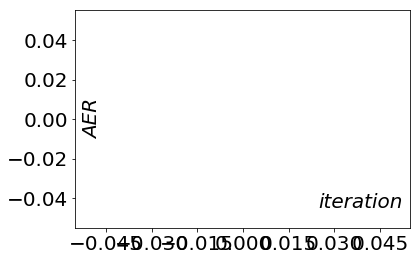

iteration    log_likelihood    AER    time
0 -26.098 0.00000 11:49
1 -15.547 0.00000 11:49
2 -10.009 0.00000 11:49
3 -4.508 0.00000 11:49
4 -1.694 0.00000 11:49
5 -0.824 0.00000 11:49
6 -0.427 0.00000 11:49
7 -0.218 0.00000 11:49
8 -0.110 0.00000 11:49
9 -0.055 0.00000 11:49
10 -0.028 0.00000 11:49
11 -0.014 0.00000 11:49
12 -0.007 0.00000 11:49
13 -0.003 0.00000 11:49
14 -0.002 0.00000 11:49
model selected on AER for random_random_3: ibm2_iter_None.txt
model selected on LLhood for random_random_3: ibm2_iter_None.txt


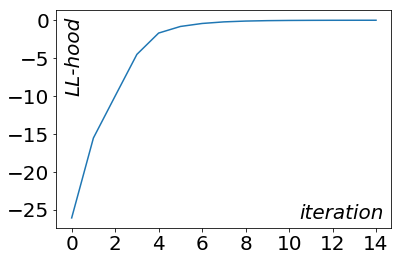

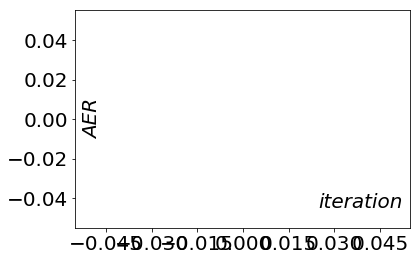

NameError: name 'load_ibm1_model' is not defined

In [15]:
s_t_pairs, s_vocabulary, t_vocabulary = datasets.training_data()
val_sentence_pairs = datasets.validation_data(s_vocabulary, t_vocabulary)
reference_alignments = datasets.validation_alignments()    

# s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_word_order()
# val_sentence_pairs = None
# reference_alignments = None    

# Run EM on training data set with AER on validation set
# using random initialization (3x)
run_em_with_initialization(initialize_lprobs_randomly, initialize_jump_probs_randomly, 'random_random_1')
run_em_with_initialization(initialize_lprobs_randomly, initialize_jump_probs_randomly, 'random_random_2')
run_em_with_initialization(initialize_lprobs_randomly, initialize_jump_probs_randomly, 'random_random_3')

# Run EM on training data set with AER on validation set
# using initialization with IBM 1 und uniform jump probabilities
run_em_with_initialization(initialize_lprobs_staged, initialize_jump_probs_uniformly, 'staged')

# run_em_with_initialization(initialize_lprobs_randomly, initialize_jump_probs_uniformly, 'random_unform_1')
# run_em_with_initialization(initialize_lprobs_randomly, initialize_jump_probs_uniformly, 'random_unform_2')
# run_em_with_initialization(initialize_lprobs_randomly, initialize_jump_probs_uniformly, 'random_unform_3')


# store model
#persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(10))


